In [19]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression

In [2]:
#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small  ## WHAT IS THIS
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [3]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [4]:
#simplified model
def CR_model_simple(t, y):
  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])
  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([J[i, a] for a in range(n_cs)])
    print(growth_intake, R[0])
    dNdt[i] = (N[i]*growth_intake)-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    dRdt[a] = (R0[a]-R[a])*d - consumption

  return np.concatenate((dNdt,dRdt))

In [5]:
# complete model
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])

  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)])
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    byproduction_tot = np.zeros((n_species, n_cs))
    for i in range(n_species):
      for b in range(n_cs):
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a]
    byproduction = np.sum(byproduction_tot)
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction

  return np.concatenate((dNdt,dRdt))

In [6]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [7]:
#solution of the model
solutions = solve_ivp(CR_model, t_span, y0, method = "BDF")

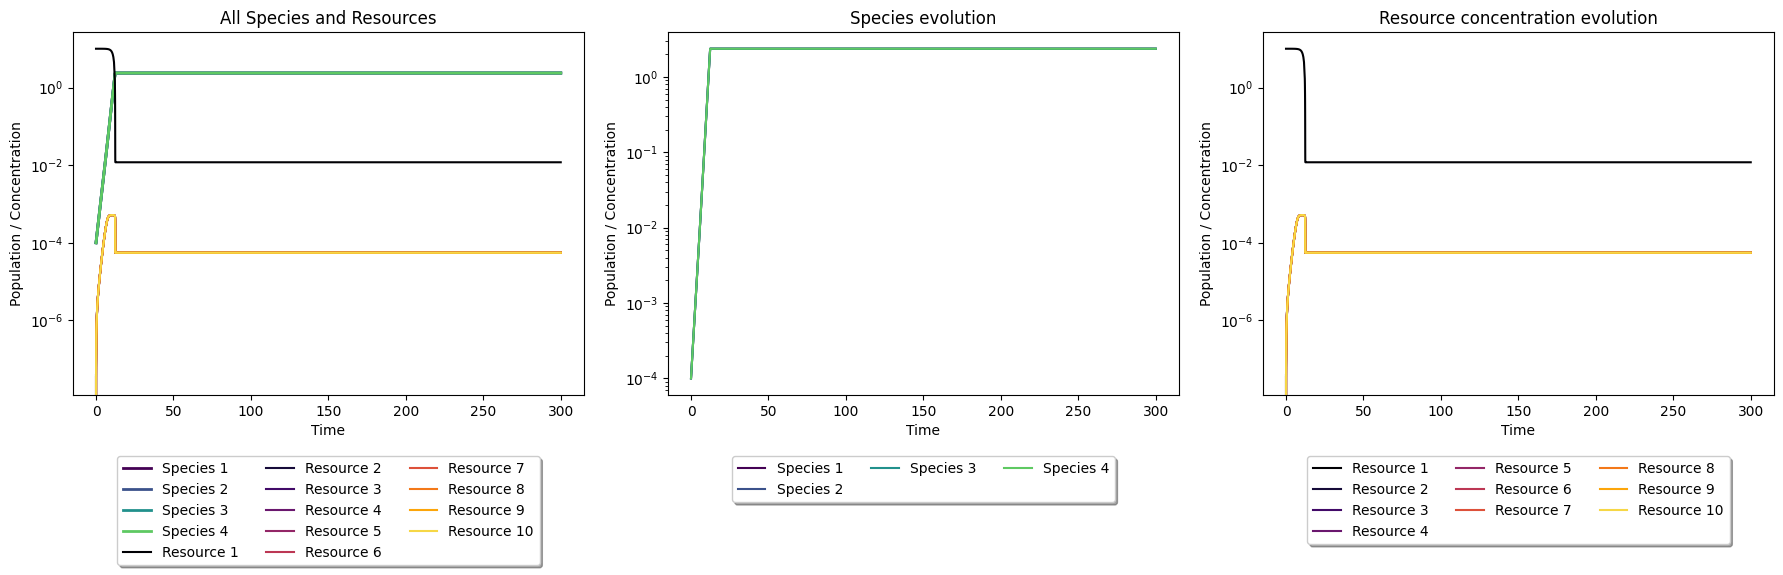

In [8]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [9]:
#Randomisation of some parameters
c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)
c

array([[0.12697151, 0.31362927, 0.34958562, 0.19728334, 0.55980933,
        0.71581535, 0.11553685, 0.63870942, 0.71899281, 0.89909401],
       [0.49740419, 0.30334688, 0.18163022, 0.05089217, 0.69576754,
        0.93965788, 0.01987666, 0.92762347, 0.41153814, 0.43899751],
       [0.96540161, 0.91273514, 0.65129535, 0.95533917, 0.91043831,
        0.03798364, 0.68813783, 0.1132955 , 0.55674418, 0.04489193],
       [0.99099231, 0.02525204, 0.77575294, 0.07319709, 0.20102612,
        0.20054462, 0.81765317, 0.082009  , 0.05157027, 0.58121787]])

In [48]:
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0, method = "BDF")

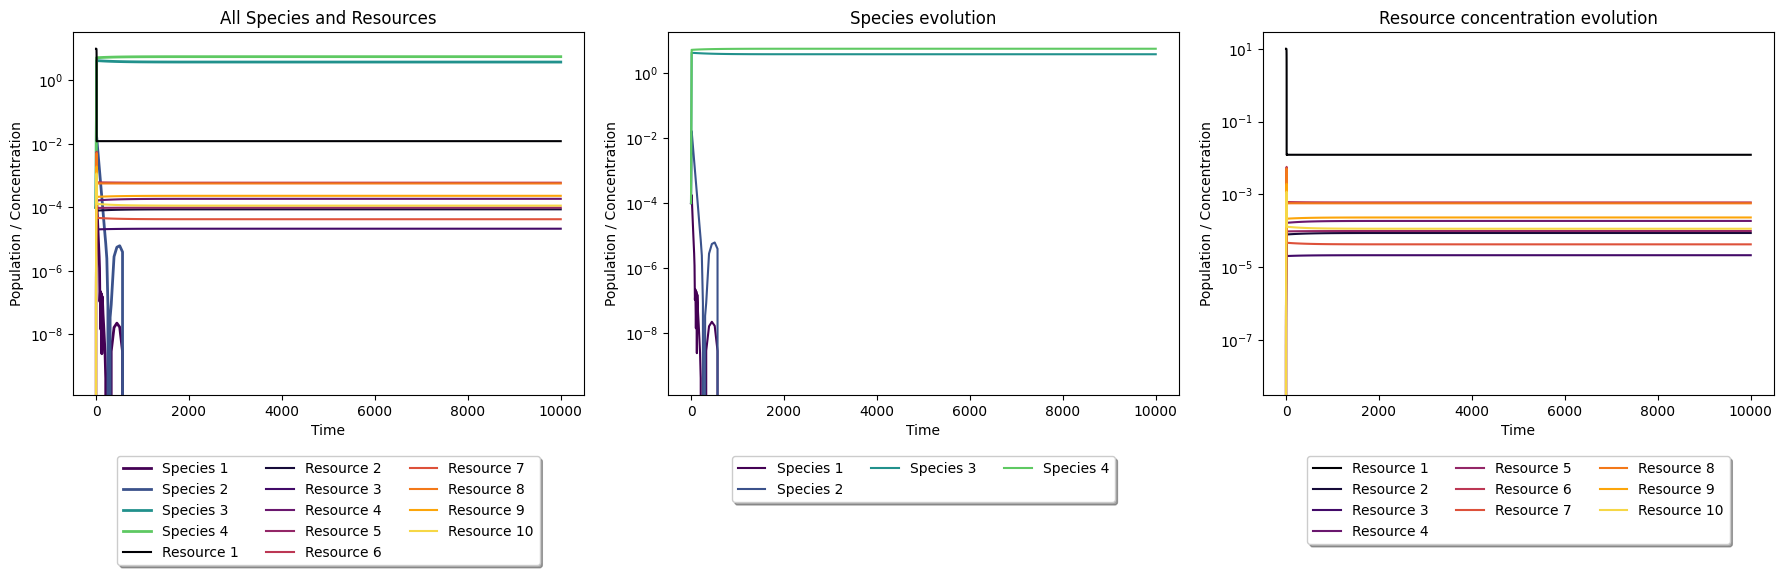

In [11]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [49]:
#random multiple simulations

sim_dict = {}
for i in range(100):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0, method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


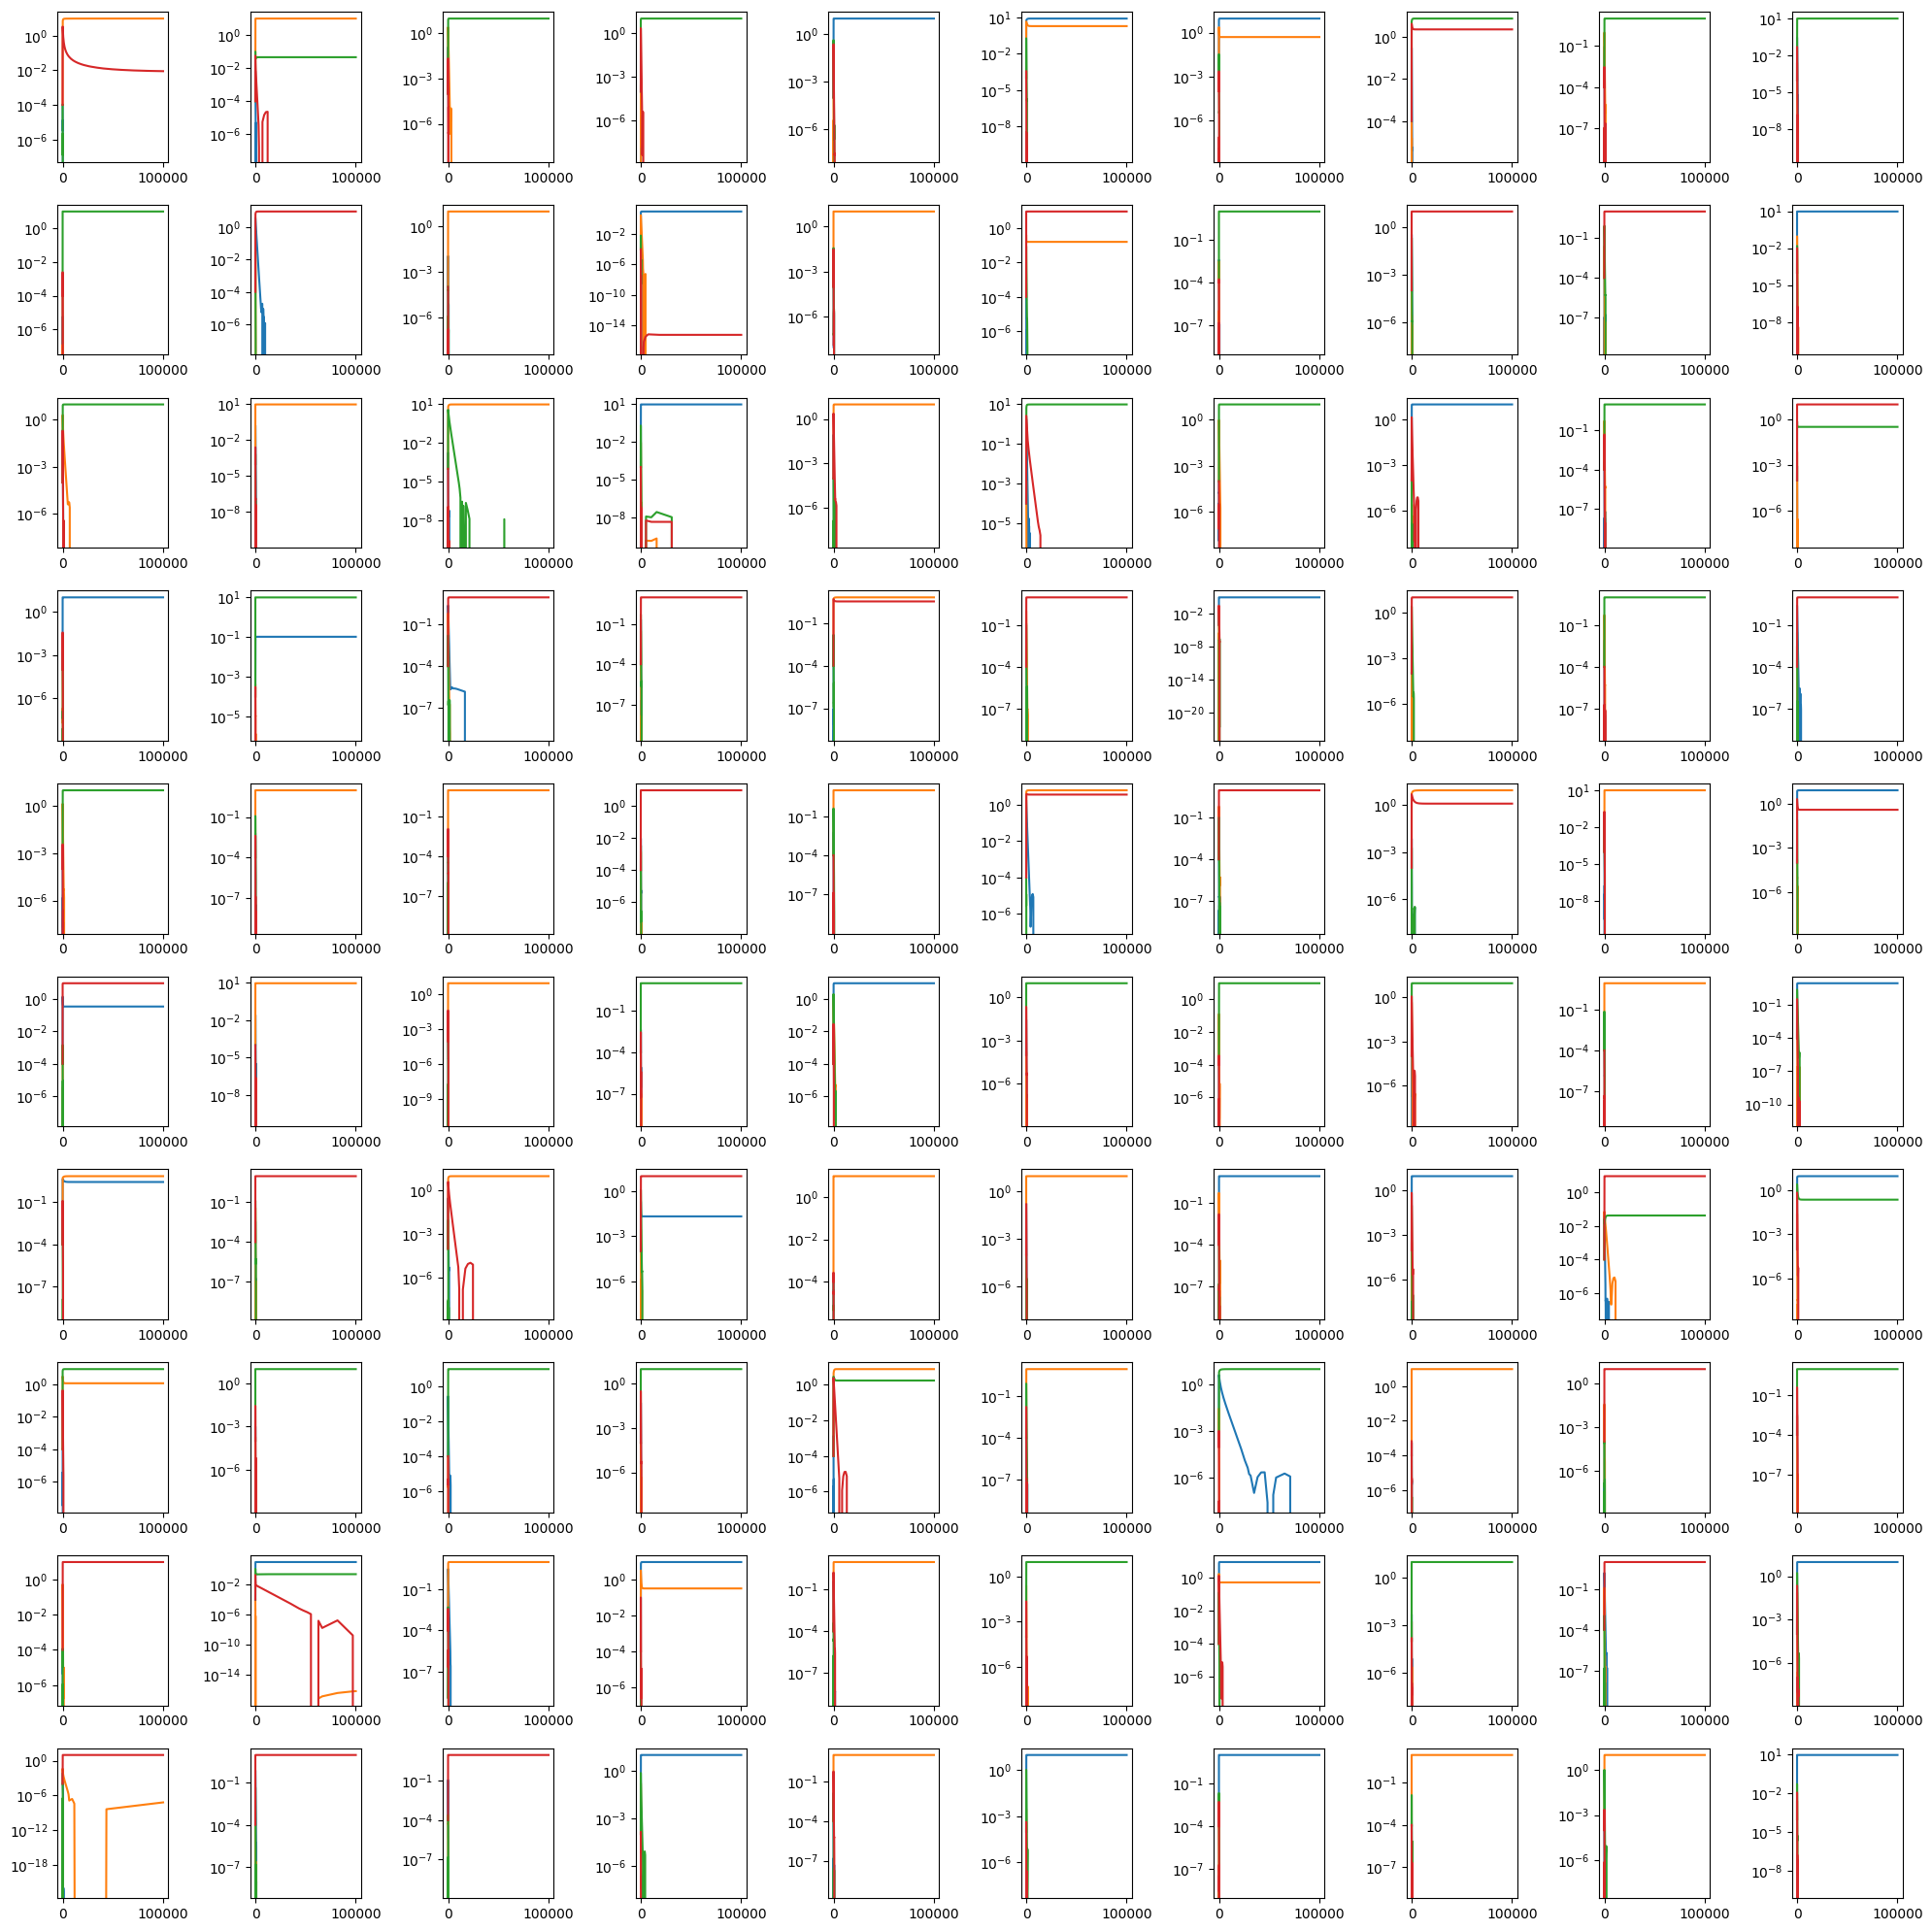

In [50]:
#plotting usinage

fig, axs = plt.subplots(10,10,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')
  ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [54]:

cohabitation_data = {"sim":[], "c" :[], "D" : []}

domination_data = {"sim":[],"c":[], "D":[]}

for i in range(len(sim_dict)):
  index_alive = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-9:
      index_alive.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][1])
  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][1])

cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
domination_df.head()

,sim,c,D
0,simulation 2,"[[0.504958958883918, 0.8936238943186604, 0.640...","[[[0.020718001901309426, 0.05622013601710264, ..."
1,simulation 3,"[[0.15147423918279135, 0.2579626010259384, 0.4...","[[[0.08910348001852478, 0.029165322431532383, ..."
2,simulation 4,"[[0.7430583175974549, 0.12080057118627485, 0.0...","[[[0.003234288236460692, 0.05658348171907829, ..."
3,simulation 8,"[[0.5697393719683131, 0.6080866931980677, 0.74...","[[[0.01452308542117744, 0.07605146374379235, 0..."
4,simulation 9,"[[0.6465501485561157, 0.028030524024160064, 0....","[[[0.047096757864998444, 0.07777612561800258, ..."
